<a href="https://colab.research.google.com/github/MELAI-1/WORKSHOPS-AND-SCIENTIFIC-OUTREACH/blob/main/%20I-X%20AI%20in%20Science-Imperial/Jets_at_LHC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torch-geometric torch-scatter torch-cluster uproot

# Let's download the data that we need!

In [ ]:
!rm -r data_train
!rm -r data_val
!rm zipped_train.zip
!rm zipped_train.zip.1
!rm zipped_val.zip
!rm zipped_val.zip.1
!mkdir -p data_train/raw/ && wget https://etpwww.etp.kit.edu/~bmaier/jets/zipped_train.zip && unzip zipped_train.zip -d data_train/raw/
!mkdir -p data_val/raw/ && wget https://etpwww.etp.kit.edu/~bmaier/jets/zipped_val.zip && unzip zipped_val.zip -d data_val/raw/

In [ ]:
import sklearn
import numpy as np
from random import randrange
import subprocess
import tqdm
import pandas as pd
import uproot
from torch_geometric.data import DataLoader
import torch
from torch import nn
import torch.nn.functional as F
import torch_cluster
from torch_cluster import knn
from torch_geometric.nn.conv import DynamicEdgeConv
from torch_geometric.nn.pool import avg_pool_x
from torch.nn import Sequential, Linear
from torch_geometric.nn import DataParallel
from torch_geometric.nn.norm import BatchNorm
from torch_scatter import scatter
import os.path as osp
import glob
from torch_geometric.data import Data
from torch_geometric.data import Dataset
import awkward as ak

import warnings
warnings.filterwarnings("ignore")

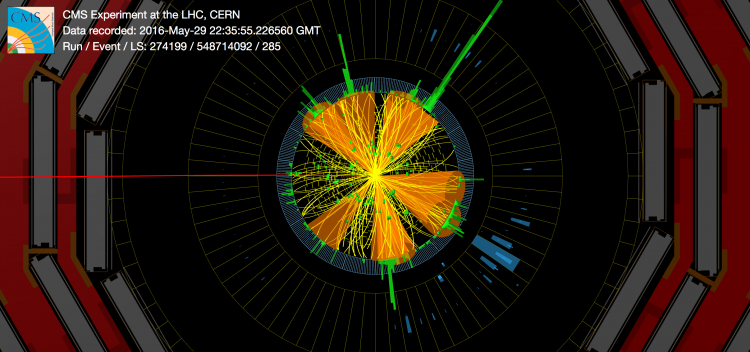


### What are jets?
*   Jets are collimated streams of particles measured in the detector
*   They arise from single quarks or gluons, or from the decay of heavy particles such as the Higgs boson or the top quark
*   From their *substructure*, we can somehow infer which particle created the jet
    *  Simple quarks or gluons lead to jets where the particles are organized in one *prong*
    *  Higgs bosons, W and Z bosons decay into two quarks, consequently the jet has two prongs
    *  The top quark decays into three quarks, the jet therefore has three prongs




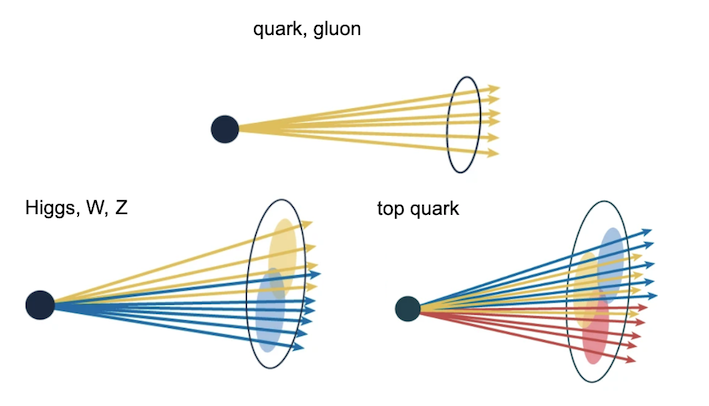

### Let's create a jet dataset where we load files and store relevant information per jet

The important information is:

*   The properties (momenta, angles, charge, ...) of the final particles that are measured in the detector and make up the jet. These properties ("features") per particle are called ```part_feats``` below. They have a shape of ```N_jets x N_part x N_feat```.

*   Some high-level features per jet (the jet momentum, direction, energy, and some substructure information). These high-level features are called ```hl_feats``` below. They are:

  * `jet_pt`: momentum of the jet in the transvere detector plane
  * `jet_eta`: pseudorapidity (an angle with respect to the beam axis) of the jet
  * `jet_phi`: the azimuthal angle of the jet, as seen as from the transverse detector plane
  * `jet_energy`: no need to explain that :P
  * `jet_nparticles`: how many are contained in the jet
  * `jet_sdmass`: the (so called "soft-drop") mass of the jet
  * `jet_tau1`: The compatibility of the jet with having one prong
  * `jet_tau2`: The compatibility of the jet with having two prongs
  * `jet_tau3`: The compatibility of the jet with having three prongs

In [ ]:
class Jets(Dataset):
    r'''
        input x0: (particles in jet)

        # truth targets = event class (S vs B)
    '''

    url = '/dummy/'

    def __init__(self, root, max_events=1e8, shuffle=True, classes=[]):
        super(Jets, self).__init__(root)

        self.strides = [0]
        self.part_feats = None
        self.truth = None
        self.hlfeats = None
        self.shuffle = shuffle
        self.max_events = max_events
        self.classes = classes
        self.fill_data()


    def fill_data(self):
        for fi,path in tqdm.tqdm(enumerate(self.raw_paths),total=len(self.raw_paths),desc='Loading input files'):
            skip_class = True
            for c in self.classes:
                if c in path:
                    skip_class = False
                    #print('Dont skip class',c)
            if skip_class:
                continue

            tmptree = uproot.open(path)['tree']

            n_evts_per_file = 5000

            # Load per-particle features
            feat_px = tmptree['part_px'].array(entry_start=0,entry_stop=n_evts_per_file)
            feat_py = tmptree['part_py'].array(entry_start=0,entry_stop=n_evts_per_file)
            feat_pz = tmptree['part_pz'].array(entry_start=0,entry_stop=n_evts_per_file)
            feat_d0val = tmptree['part_d0val'].array(entry_start=0,entry_stop=n_evts_per_file)
            feat_dzval = tmptree['part_dzval'].array(entry_start=0,entry_stop=n_evts_per_file)
            feat_charge = tmptree['part_charge'].array(entry_start=0,entry_stop=n_evts_per_file)
            feat_e = tmptree['part_energy'].array(entry_start=0,entry_stop=n_evts_per_file)

            # Preprocess per-particle features, only take the top 40 particles per jet
            n_part = 50
            tmp_feat_px = np.array(ak.fill_none(ak.pad_none(feat_px, n_part, clip=True).to_list(),0))
            tmp_feat_py = np.array(ak.fill_none(ak.pad_none(feat_py, n_part, clip=True).to_list(),0))
            tmp_feat_pz = np.array(ak.fill_none(ak.pad_none(feat_pz, n_part, clip=True).to_list(),0))
            tmp_feat_d0val = np.array(ak.fill_none(ak.pad_none(feat_d0val, n_part, clip=True).to_list(),0))
            tmp_feat_dzval = np.array(ak.fill_none(ak.pad_none(feat_dzval, n_part, clip=True).to_list(),0))
            tmp_feat_charge = np.array(ak.fill_none(ak.pad_none(feat_charge, n_part, clip=True).to_list(),0))
            tmp_feat_e = np.array(ak.fill_none(ak.pad_none(feat_e, n_part, clip=True).to_list(),0))
            tmp_feats = np.stack((tmp_feat_px,tmp_feat_py,tmp_feat_pz,tmp_feat_e,tmp_feat_d0val,tmp_feat_dzval,tmp_feat_charge),axis=-1)

            # Per-jet high-level features
            hlfeat_pt = tmptree['jet_pt'].array(entry_start=0,entry_stop=n_evts_per_file)
            hlfeat_eta = tmptree['jet_eta'].array(entry_start=0,entry_stop=n_evts_per_file)
            hlfeat_phi = tmptree['jet_phi'].array(entry_start=0,entry_stop=n_evts_per_file)
            hlfeat_energy = tmptree['jet_energy'].array(entry_start=0,entry_stop=n_evts_per_file)
            hlfeat_nparticles = tmptree['jet_nparticles'].array(entry_start=0,entry_stop=n_evts_per_file)
            hlfeat_mass = tmptree['jet_sdmass'].array(entry_start=0,entry_stop=n_evts_per_file)
            hlfeat_tau1 = tmptree['jet_tau1'].array(entry_start=0,entry_stop=n_evts_per_file)
            hlfeat_tau2 = tmptree['jet_tau2'].array(entry_start=0,entry_stop=n_evts_per_file)
            hlfeat_tau3 = tmptree['jet_tau3'].array(entry_start=0,entry_stop=n_evts_per_file)
            tmp_hlfeats = np.stack((hlfeat_pt,hlfeat_eta,hlfeat_phi,hlfeat_energy,hlfeat_nparticles,hlfeat_mass,hlfeat_tau1,hlfeat_tau2,hlfeat_tau3),axis=-1)

            # Load truth
            is_notqcd = tmptree['label_QCD'].array(entry_start=0,entry_stop=n_evts_per_file)


            if self.part_feats is None:
                self.part_feats = tmp_feats
                self.truth = np.array(is_notqcd).astype(np.float32)
                self.hlfeats = tmp_hlfeats
            else:
                self.part_feats = np.concatenate((self.part_feats,tmp_feats))
                self.truth = np.concatenate((self.truth,np.array(is_notqcd).astype(np.float32)))
                self.hlfeats = np.concatenate((self.hlfeats,tmp_hlfeats))

        if self.shuffle:
            import random
            indices = [i for i in range(len(self.truth))]
            random.shuffle(indices)

            self.part_feats = self.part_feats[indices]
            self.truth = self.truth[indices]
            self.hlfeats = self.hlfeats[indices]

        self.part_feats = self.part_feats[:self.max_events]
        self.truth = np.logical_not(self.truth[:self.max_events]) # Define QCD as 0, Top/Higgs as 1
        self.hlfeats = self.hlfeats[:self.max_events]

        print('\n')
        print(f'Total length: {len(self.truth)}')
        print(f'Of class 0: {np.count_nonzero(self.truth)}')
        print(f'Of class 1: {len(self.truth)-np.count_nonzero(self.truth)}\n')

    def download(self):
        raise RuntimeError(
            'Dataset not found. Please download it from {} and move all '
            '*.z files to {}'.format(self.url, self.raw_dir))

    def len(self):
        return len(self.truth)

    @property
    def raw_file_names(self):
        raw_files = sorted(glob.glob(osp.join(self.raw_dir, '*.root')))
        return raw_files

    @property
    def processed_file_names(self):
        return []

    def get(self, idx):
        part_feats = np.array(self.part_feats[idx],dtype=np.float32)

        Npart = np.count_nonzero(part_feats[:,0])
        x_part = part_feats[:Npart,:]

        # convert to torch
        x = torch.nan_to_num(torch.from_numpy(part_feats[:Npart,:]))
        x_part = torch.nan_to_num(torch.from_numpy(x_part).float())

        y = torch.from_numpy(np.array(self.truth[idx],dtype=np.float32)).float()

        edge_index = torch.empty((2,0), dtype=torch.long)

        # PUT HERE: Load here the high-level features into x, which is currently a placeholder
        x = torch.from_numpy(np.array(self.hlfeats[idx])).unsqueeze(0)

        return Data(x=x, edge_index=edge_index, y=y,
                        x_part=x_part)


# Let's load the datasets!
There are three classes available in the dataset: jets from "`Top`" quarks, jets from "`QCD`", jets from "`HToBB`" (Higgs decaying to a pair of b quarks). Since we're doing binary classification, you need to choose if you want to learn to distinguish Higgs jets from QCD or Top jets from QCD.

In [ ]:
batchsize = 128
maxevents = 12000 # can't go higher than 20000
data_train = Jets("/content/data_train/",max_events=maxevents,shuffle=True,classes=['Top','QCD'])
train_loader = DataLoader(data_train, batch_size=batchsize,follow_batch=['x_part'])
data_val = Jets("/content/data_val/",max_events=maxevents,shuffle=True,classes=['Top','QCD'])
val_loader = DataLoader(data_val, batch_size=batchsize,follow_batch=['x_part'])

## !!! Task 1: Plotting the high-level features

Plot the high-level features in histograms (plt.hist(...)) separately (but in the same plot) for both QCD and Top (or Higgs) classes. You can use `data_train.truth==0` or `data_train.truth==1` to select subarrays of `data_train.hlfeats` corresponding to the two classes.

In [ ]:
feat_to_plot = 4   #0,1,2,3,4,5,6,7,8
fig,ax = plt.subplots()
plt.hist(-->FILLHERE)
plt.hist(-->FILLHERE)
plt.xlabel(f"Feat {feat_to_plot}")
plt.ylabel("Counts")
plt.legend()

# GNN Section
## Let's define the Graph Neural Network below!

In [ ]:
def global_add_pool(x, batch, size=None):
    """
    Globally pool node embeddings into graph embeddings, via elementwise sum.
    Pooling function takes in node embedding [num_nodes x emb_dim] and
    batch (indices) and outputs graph embedding [num_graphs x emb_dim].

    Args:
        x (torch.tensor): Input node embeddings
        batch (torch.tensor): Batch tensor that indicates which node
        belongs to which graph
        size (optional): Total number of graphs. Can be auto-inferred.

    Returns: Pooled graph embeddings

    """
    size = batch.max().item() + 1 if size is None else size
    return scatter(x, batch, dim=0, dim_size=size, reduce='add')


class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()

        hidden_dim = 32

        self.part_encode = nn.Sequential(
            nn.Linear(7, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU()
        )

        self.conv = DynamicEdgeConv(
            nn=nn.Sequential(nn.Linear(2*hidden_dim, hidden_dim), nn.ELU()),
            k=24
        )

        self.output = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 8),
            nn.ELU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self,
                x_part,
                batch_part):

        x_part_enc = self.part_encode(x_part)

        # First graph convolution
        feats1 = self.conv(x=(x_part_enc, x_part_enc), batch=(batch_part, batch_part))
        # Second graph convolution
        feats2 = self.conv(x=(feats1, feats1), batch=(batch_part, batch_part))
        # Third graph convolution
        feats3 = self.conv(x=(feats2, feats2), batch=(batch_part, batch_part))


        batch = batch_part
        out  = global_add_pool(feats3, batch_part)
        out = self.output(out)

        return out, batch

## Let's create an instance of the GNN and define optimizer and learning rate schedule

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')
gnn = GNN().to(device)
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

cpu


In [ ]:
def train():
    gnn.train()
    counter = 0

    total_loss = 0
    for data in tqdm.tqdm(train_loader,desc='Batch'):
        counter += 1

        data = data.to(device)
        optimizer.zero_grad()
        out = gnn(data.x_part,
                    data.x_part_batch)

        #loss = torch.nn.BCELoss()(torch.squeeze(out[0]).view(-1),data.y)
        loss = nn.MSELoss()(torch.squeeze(out[0]).view(-1),data.y)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    return total_loss / data_train.max_events

@torch.no_grad()
def val():
    gnn.eval()
    counter = 0
    all_truth = []
    all_pred = []
    total_loss = 0
    for data in tqdm.tqdm(val_loader,desc='Batch'):
        counter += 1

        data = data.to(device)
        with torch.no_grad():
            out = gnn(data.x_part,
                       data.x_part_batch)


            #loss = torch.nn.BCELoss()(torch.squeeze(out[0]).view(-1),data.y)
            loss = nn.MSELoss()(torch.squeeze(out[0]).view(-1),data.y)
            total_loss += loss.item()
            all_truth.extend(data.y.tolist())
            all_pred.extend(torch.squeeze(out[0]).view(-1).tolist())

    return total_loss / data_val.max_events, all_truth, all_pred


## Now let's actually train the GNN and keep track of the predicted and true labels per jet example!



In [ ]:
all_val_truth = []
all_val_pred = []

for epoch in range(1, 5):
    print(f'Training Epoch {epoch} on {data_train.max_events} jets')
    loss = train()
    scheduler.step()

    print(f'Validating Epoch {epoch} on {data_val.max_events} jets')
    loss_val, truth_val, pred_val = val()
    all_val_truth.append(truth_val)
    all_val_pred.append(pred_val)

    print('Epoch {:03d}, Loss: {:.8f}, ValLoss: {:.8f}'.format(
        epoch, loss, loss_val))

all_val_truth = np.array(all_val_truth)
all_val_pred = np.array(all_val_pred)

## Plotting the GNN output for the two classes


In [ ]:
import matplotlib.pyplot as plt
bins = np.linspace(0,1,25)
fig,ax = plt.subplots()
plt.hist(all_val_pred[-1][all_val_truth[-1]==0],bins=bins,histtype='step',density=True,label='class 0')
plt.hist(all_val_pred[-1][all_val_truth[-1]==1],bins=bins,histtype='step',density=True,label='class 1')
plt.xlabel("GNN output score")
plt.ylabel("Norm. to unit area")
plt.legend()

## !!! Task 2:

* Build a ROC curve from the output and calculate the AUC (Area Under the Curve)

* How does the performance depend on (pick one, you don't have to study them all):
   * The number of particles per jet that you consider
   * The number of graph convolutions
   * The number of nearest neighbors in these convolutions
   * The choice of input features - whether you take the full set of features or only the momenta ```px,py,pz```



## Function to construct ROC curve

In [ ]:
from sklearn import metrics

def compute_roc_auc(predictions, truths, n_steps=1000, plot=False):
    thresholds = np.linspace(0, 1, n_steps)
    tpr_list = []
    fpr_list = []

    positives = truths == 1
    negatives = truths == 0

    for thresh in thresholds:
        preds_positive = predictions >= thresh

        tp = np.sum(preds_positive & positives)
        fp = np.sum(preds_positive & negatives)
        fn = np.sum(~preds_positive & positives)
        tn = np.sum(~preds_positive & negatives)

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_array = np.array(tpr_list)
    fpr_array = np.array(fpr_list)

    # Compute AUC using the trapezoidal rule
    auc = np.abs(np.trapz(tpr_array, fpr_array))

    if plot:
        plt.figure(figsize=(6, 6))
        plt.plot(fpr_array, tpr_array, label=f'ROC curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random guessing')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    return fpr_array, tpr_array, auc

### Complete the four lines below.


In [ ]:
scores_class_0 = -->FILLHERE
scores_class_1 = -->FILLHERE
y_class_0 = -->FILLHERE
y_class_1 = -->FILLHERE

all_scores = np.concatenate((scores_class_0,scores_class_1))
all_y = np.concatenate((y_class_0,y_class_1))
fpr, tpr, auc = compute_roc_auc(all_scores, all_y, plot=True)

# DNN Section
## Simple Feed-forward DNN with high-level features

Now, instead of using the jet constituents in a GNN, let's train a simple DNN using only the high-level features characterizing the jet.

In [ ]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()

        self.output = nn.Sequential(
            nn.Linear(9, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 8),
            nn.ELU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self,
                x):

        out = self.output(x)

        return out

In [ ]:
dnn = DNN().to(device)
optimizer = torch.optim.Adam(dnn.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [ ]:
def train_dnn():
    dnn.train()
    counter = 0

    total_loss = 0
    for data in tqdm.tqdm(train_loader,desc='Batch'):
        counter += 1

        data = data.to(device)
        optimizer.zero_grad()
        out = dnn(data.x)
        #loss = torch.nn.BCELoss()(torch.squeeze(out[0]).view(-1),data.y)
        loss = nn.MSELoss()(torch.squeeze(out),data.y)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    return total_loss / data_train.max_events

@torch.no_grad()
def val_dnn():
    dnn.eval()
    counter = 0
    all_truth = []
    all_pred = []
    total_loss = 0
    for data in tqdm.tqdm(val_loader,desc='Batch'):
        counter += 1

        data = data.to(device)
        with torch.no_grad():
            out = dnn(data.x)

            #loss = torch.nn.BCELoss()(torch.squeeze(out[0]).view(-1),data.y)
            loss = nn.MSELoss()(torch.squeeze(out),data.y)
            total_loss += loss.item()
            all_truth.extend(data.y.tolist())
            all_pred.extend(torch.squeeze(out).tolist())

    return total_loss / data_val.max_events, all_truth, all_pred


In [ ]:
all_val_dnn_truth = []
all_val_dnn_pred = []

for epoch in range(1, 5):
    print(f'Training Epoch {epoch} on {data_train.max_events} jets')
    loss = train_dnn()
    scheduler.step()

    print(f'Validating Epoch {epoch} on {data_val.max_events} jets')
    loss_val, truth_val, pred_val = val_dnn()
    all_val_dnn_truth.append(truth_val)
    all_val_dnn_pred.append(pred_val)

    print('Epoch {:03d}, Loss: {:.8f}, ValLoss: {:.8f}'.format(
        epoch, loss, loss_val))

all_val_dnn_truth = np.array(all_val_dnn_truth)
all_val_dnn_pred = np.array(all_val_dnn_pred)

## !!! Task 3: Compute the ROC curve / AUC for the DNN

## !!! Task 4: Check which high-level feature is the most useful (by leaving that feature out in another DNN training and checking the degradation in AUC)

Tip: You should not have to modify the Jet class definition. Just splice the `x` array in the line `out = self.output(x)` of the DNN to leave out a certain feature.

## !!! Task 5 (bonus): Turn the DNN into an autoencoder, starting from the 9 features, compressing them into a bottleneck, and reconstructing the 9 features again, and quantify the AUC for this unsupervised training.